In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import folium
from pyspark.sql import SparkSession, Window, functions as F
from pyspark.sql.functions import countDistinct, col, date_format
import numpy as np
import pyspark.sql.functions as func
from pyspark.sql.functions import sum, avg, count, lag, date_sub, split
from pyspark.sql.window import Window
from pyspark.sql.types import (
    StringType,
    LongType,
    DoubleType,
    StructField,
    StructType,
    FloatType
)
from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Start Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/18 23:21:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# load BNPL dataset
consumer = spark.read.csv("../data/tables/tbl_consumer.csv", header=True, sep="|")
details = spark.read.parquet("../data/tables/consumer_user_details.parquet")
merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")

In [4]:
# load all transactions datasets
paths=['../data/tables/transactions_20210228_20210827_snapshot',
       '../data/tables/transactions_20210828_20220227_snapshot',
       '../data/tables/transactions_20220228_20220828_snapshot']

first = 1
for path in paths:
    if first:
        transactions = spark.read.parquet(path)
        print(f'added {path.split("/")[3]}')
        first = 0
    else:
        append_transactions = spark.read.parquet(path)
        transactions = transactions.union(append_transactions)
        print(f'added {path.split("/")[3]}')

added transactions_20210228_20210827_snapshot


added transactions_20210828_20220227_snapshot


added transactions_20220228_20220828_snapshot


In [5]:
age = gpd.read_file("../data/abs/sa2_age.gml")

In [6]:
# load poa_to_sa2 dataset
poa_to_sa2 = spark.read.csv("../data/curated/poa_w_sa2.csv", header=True)

In [7]:
# rename columns
merchants = merchants.withColumnRenamed('name', 'merchant_name')
consumer = consumer.withColumnRenamed('name', 'consumer_name')

In [8]:
# Join consumers with their respective details
consumer_detail = consumer.join(details, on="consumer_id")

# Join consumers with their respective transactions
consumer_trx = consumer_detail.join(transactions, on="user_id")

# Join transactions with the respective merchants
df_trx = consumer_trx.join(merchants, on="merchant_abn")

In [9]:
# translate postcodes in transaction to sa2 codes
sa2_cols = ['poa_name_2016', 'sa2_maincode_2016', 'sa2_name_2016', 'geometry']
df_trx_sa2 = (df_trx \
                .join(poa_to_sa2[sa2_cols], 
                     on=[df_trx['postcode'] == poa_to_sa2['poa_name_2016']],
                     how='inner')
                .drop('poa_name_2016')
             )

In [10]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
@F.udf(StringType())
def normalize_tags(col):
    return col.replace("(", "[").replace(")", "]")[1:-1]

df_trx_sa2 = df_trx_sa2.withColumn("tags", normalize_tags(F.col("tags")))

In [11]:
df_trx_sa2 = df_trx_sa2.withColumn("categories", F.regexp_extract("tags", "(?<=\[)(.*?)(?=\])", 1))
df_trx_sa2 = df_trx_sa2.withColumn("revenue_level", F.regexp_extract("tags", "(?<=,\s\[)([a-e]+?)(?=\],)", 1))
df_trx_sa2 = df_trx_sa2.withColumn("take_rate", F.regexp_extract("tags", "(?<=\[take rate: )(.*?)(?=\])", 1))
df_trx_sa2 = df_trx_sa2.withColumn("take_rate", F.col("take_rate").astype(FloatType()))

In [12]:
df_trx_sa2 = df_trx_sa2[df_trx_sa2["dollar_value"] >= 35]

In [13]:
@F.udf(StringType())
def clean_string(col):
    col = col.lower()
    return " ".join(col.split())

df_trx_sa2 = df_trx_sa2.withColumn("categories", clean_string(F.col("categories")))

In [14]:
@F.udf(FloatType())
def get_revenue(take_rate, dollar_value):
    return (take_rate / 100) * dollar_value

df_trx_sa2 = df_trx_sa2.withColumn("revenue", get_revenue(F.col("take_rate"), F.col("dollar_value")))

In [15]:
df_trx_sa2 = df_trx_sa2.drop('tags')

In [16]:
# calculate population of age above 20
left_age = 25
right_age = 29
age['males_age_20_50'] = age['males_age_20_24']
age['females_age_20_50'] = age['females_age_20_24']
age['persons_age_20_50'] = age['persons_age_20_24']

while right_age < 50:

    age['males_age_20_50'] += age[f'males_age_{left_age}_{right_age}']
    age['females_age_20_50'] += age[f'females_age_{left_age}_{right_age}']
    age['persons_age_20_50'] += age[f'persons_age_{left_age}_{right_age}']
    
    left_age += 5
    right_age += 5

---

In [17]:
df_trx_sa2.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- sa2_maincode_2016: string (nullable = true)
 |-- sa2_name_2016: string (nullable = true)
 |-- geometry: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: float (nullable = true)
 |-- revenue: float (nullable = true)



In [18]:
df_trx_sa2.show(1, vertical=True)

-RECORD 0---------------------------------
 merchant_abn      | 23661821077          
 user_id           | 13882                
 consumer_id       | 151968               
 consumer_name     | Scott Dean           
 address           | 09010 Brandi Prairie 
 state             | NSW                  
 postcode          | 2016                 
 gender            | Male                 
 dollar_value      | 51.527409870273424   
 order_id          | f20fdc13-9500-483... 
 order_datetime    | 2021-08-19           
 merchant_name     | Suspendisse Eleif... 
 sa2_maincode_2016 | 117031335.0          
 sa2_name_2016     | Redfern - Chippen... 
 geometry          | POLYGON ((151.196... 
 categories        | computer programm... 
 revenue_level     | c                    
 take_rate         | 3.0                  
 revenue           | 1.5458223            
only showing top 1 row



In [19]:
def get_cat_merchant_data(product_category):
    df_cat = df_trx_sa2.filter(F.col('category') == product_category)
    
    # unique consumer per merchant
    df_cat.groupby('category').

SyntaxError: invalid syntax (146930404.py, line 5)

In [20]:
product_category = "florists supplies, nursery stock, and flowers"

df_cat = df_trx_sa2.filter(F.col('categories') == product_category)
df_cat = (df_cat.withColumn("order_year_month", 
                            date_format(col("order_datetime"), 'yyyy-MM')
                .alias("yyyy-MM")))



# average order transactionn value, 
# total transaction frequency, unique consumer per merchant
sdf = (df_cat.groupby(['merchant_abn', 'order_year_month'])
             .agg(avg('dollar_value'),
                  count('order_id'), 
                  countDistinct('consumer_id'),
                  sum('dollar_value'))
             .withColumnRenamed("avg(dollar_value)", 'avg_order_val')
             .withColumnRenamed("count(order_id)", 'trx_count')
             .withColumnRenamed("count(consumer_id)", 
                                'distinct_consumer')
             .withColumnRenamed("sum(dollar_value)", 'total_sales'))


# calculate the average monthly growth
# exclude 2021-02 as it contains only one day
df_cat = df_cat.filter(F.col('order_year_month') != '2021-02')
df_cat_grouped = (df_cat.groupBy(["merchant_abn", 'order_year_month'])
                        .sum("dollar_value")
                        .sort(['merchant_abn', 'order_year_month']))

win = Window.partitionBy("merchant_abn").orderBy('order_year_month')
df_sales_diff = (df_cat_grouped.withColumn('sales_change', df_cat_grouped['sum(dollar_value)'] - lag(df_cat_grouped['sum(dollar_value)']).over(win))
                               .withColumn('last_sales',F.lag(df_cat_grouped['sum(dollar_value)']).over(win))
                               .withColumn('growth_perc', F.round((F.col('sales_change')/F.col('last_sales'))*100,2)))

df_sales_growth = (df_sales_diff.groupby('merchant_abn')
                   .agg(avg('growth_perc'))
                   .withColumn("avg(growth_perc)", 
                               F.round(F.col("avg(growth_perc)"), 2))
                   .withColumnRenamed('avg(growth_perc)', 'avg_monthly_growth'))
df_sales_diff = (df_sales_diff.na.fill(value=0, subset=["growth_perc"]))


# consumer state
df_state = (df_cat[['merchant_abn', 'order_year_month', 'state', 'order_id']]
            .groupby(['merchant_abn', 'order_year_month']).pivot("state").count())
df_state = (df_state.na.fill(value=0,
                             subset=["ACT", "NSW", "QLD", 
                                     "SA", "TAS", "VIC", "WA"]))

# merchant number of active months
df_active = (df_cat.groupby(['merchant_abn', 'order_year_month'])
             .agg(countDistinct('order_datetime'))
             .withColumnRenamed("count(order_datetime)", "num_active_days"))


# latest 12 months total transaction value
# col_earlist_date = date_sub(F.max('order_datetime'), 365).alias('earliest')
# col_latest_date = F.max('order_datetime').alias('lastest')
# last_12_m_date_range = df_cat.select(col_earlist_date, col_latest_date)
# date_range = last_12_m_date_range.collect()

# last_12_m_trx = df_cat.filter(F.col('order_datetime') >= date_range[0][0])
# df_annual_trx_val = (last_12_m_trx.groupby('merchant_abn')
#                                   .sum('dollar_value')
#                                   .withColumnRenamed('sum(dollar_value)', 
#                                                      'annual_trx_val'))

# assume that sa2 with most trx frequency is the merchant's SA2
# w = Window.partitionBy(['merchant_abn', 'sa2_maincode_2016'])
# df_merchant_sa2 = (df_cat['merchant_abn', 'sa2_maincode_2016', 'order_id']
#                    .groupby(['merchant_abn', 'sa2_maincode_2016'])
#                    .agg(count('order_id'))
#                    .sort('merchant_abn'))

# df_merchant_sa2 = df_merchant_sa2.withColumn('max_count', 
#                                              F.max('count(order_id)').over(w))\
#                     .where(F.col('count(order_id)') == F.col('max_count'))\
#                     .drop('max_count')


# Join all features to sdf by merchant_abn
def join_agg(sdf1, sdf2):
    '''
        take two dataframes and join the two dataframes
    '''
    sdf1 = (sdf1 \
               .join(sdf2, 
                     on=['merchant_abn', 'order_year_month'], 
                     how='inner')
           )
    return sdf1

sdf = join_agg(sdf, df_sales_diff[['merchant_abn', 'order_year_month', 'growth_perc']])
sdf = join_agg(sdf, df_state)
sdf = join_agg(sdf, df_active)
# sdf = join_agg(sdf, df_annual_trx_val)

sdf = sdf.withColumn('order_month', 
                     split(sdf['order_year_month'], '-') \
                     .getItem(1).cast('INT'))

In [21]:
sdf = sdf.withColumn('order_month', 
                     split(sdf['order_year_month'], '-') \
                     .getItem(1).cast('INT'))

In [22]:
dict_null = {col:sdf.filter(sdf[col].isNull()).count() 
             for col in sdf.columns}
dict_null

22/09/18 21:43:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:09 WARN RowBasedKeyValueBatch: Calling spill() on

[220.730s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 84.0 (TID 955): Retried waiting for GCLocker too often allocating 8388610 words
22/09/18 21:43:12 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.


22/09/18 21:43:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:43:45 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/18 21:44:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:44:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/18 21:44:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:44:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:44:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:44:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:44:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:44:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


{'merchant_abn': 0,
 'avg_order_val': 0,
 'trx_count': 0,
 'distinct_consumer': 0,
 'avg_monthly_growth': 0,
 'ACT': 0,
 'NSW': 0,
 'QLD': 0,
 'SA': 0,
 'TAS': 0,
 'VIC': 0,
 'WA': 0,
 'num_active_months': 0,
 'annual_trx_val': 0}

### Model Training

In [23]:
sdf.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- order_year_month: string (nullable = true)
 |-- avg_order_val: double (nullable = true)
 |-- trx_count: long (nullable = false)
 |-- distinct_consumer: long (nullable = false)
 |-- total_sales: double (nullable = true)
 |-- growth_perc: double (nullable = false)
 |-- ACT: long (nullable = true)
 |-- NSW: long (nullable = true)
 |-- QLD: long (nullable = true)
 |-- SA: long (nullable = true)
 |-- TAS: long (nullable = true)
 |-- VIC: long (nullable = true)
 |-- WA: long (nullable = true)
 |-- num_active_days: long (nullable = false)
 |-- order_month: integer (nullable = true)



In [25]:
df = sdf.toPandas()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3543 entries, 0 to 3542
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   merchant_abn       3543 non-null   int64  
 1   order_year_month   3543 non-null   object 
 2   avg_order_val      3543 non-null   float64
 3   trx_count          3543 non-null   int64  
 4   distinct_consumer  3543 non-null   int64  
 5   total_sales        3543 non-null   float64
 6   growth_perc        3543 non-null   float64
 7   ACT                3543 non-null   int64  
 8   NSW                3543 non-null   int64  
 9   QLD                3543 non-null   int64  
 10  SA                 3543 non-null   int64  
 11  TAS                3543 non-null   int64  
 12  VIC                3543 non-null   int64  
 13  WA                 3543 non-null   int64  
 14  num_active_days    3543 non-null   int64  
 15  order_month        3543 non-null   int32  
dtypes: float64(3), int32(1),

In [27]:
df.columns

Index(['merchant_abn', 'order_year_month', 'avg_order_val', 'trx_count',
       'distinct_consumer', 'total_sales', 'growth_perc', 'ACT', 'NSW', 'QLD',
       'SA', 'TAS', 'VIC', 'WA', 'num_active_days', 'order_month'],
      dtype='object')

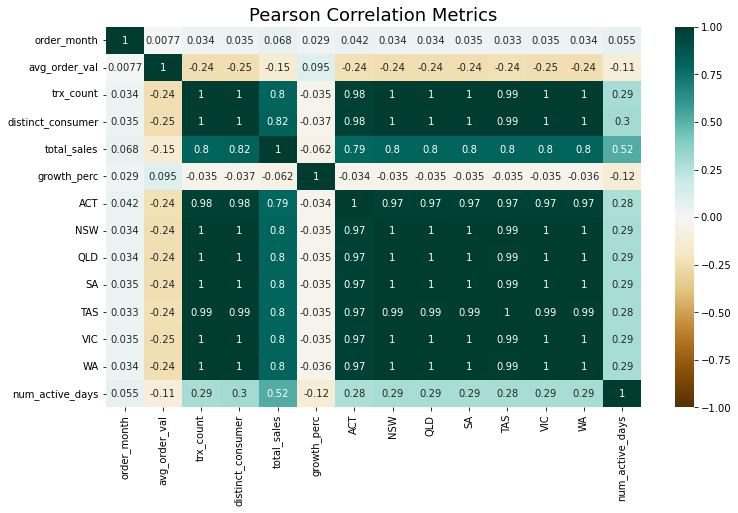

In [35]:
fields = ['order_month', 'avg_order_val', 'trx_count',
          'distinct_consumer', 'total_sales', 'growth_perc', 'ACT', 'NSW', 'QLD',
          'SA', 'TAS', 'VIC', 'WA', 'num_active_days']
plt.figure(figsize=(12,7))
sns.heatmap(df[fields].corr(method='pearson'), 
            vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.title('Pearson Correlation Metrics', fontsize=18)
plt.show()

In [55]:
from statsmodels.formula.api import ols, glm

fit = ols(
    formula="total_sales ~ order_month + avg_order_val + trx_count + distinct_consumer + ACT + NSW + QLD + SA + TAS + VIC + WA + num_active_days",
    data=df
).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:            total_sales   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     2112.
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        23:37:59   Log-Likelihood:                -39466.
No. Observations:                3543   AIC:                         7.896e+04
Df Residuals:                    3531   BIC:                         7.903e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.661e+04   1059.60

In [65]:
fitter = ols(
    formula="total_sales ~ order_month + avg_order_val + trx_count + distinct_consumer + NSW + QLD + VIC + WA + num_active_days",
    data=df
).fit()

print(fitter.summary())

                            OLS Regression Results                            
Dep. Variable:            total_sales   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     2583.
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        23:39:30   Log-Likelihood:                -39466.
No. Observations:                3543   AIC:                         7.895e+04
Df Residuals:                    3533   BIC:                         7.901e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.662e+04   1059.25

In [66]:
fit.aic, fitter.aic, f"abs diff: {abs(fitter.aic - fit.aic)}"

(78955.25067309011, 78951.62477230722, 'abs diff: 3.6259007828921312')

In [32]:
df[df['merchant_abn']==46666227102]

,merchant_abn,order_year_month,avg_order_val,trx_count,distinct_consumer,total_sales,growth_perc,ACT,NSW,QLD,SA,TAS,VIC,WA,num_active_days,order_month
449,46666227102,2021-12,530.708724,3,3,1592.126171,92.59,0,0,1,0,0,1,1,2,12
453,46666227102,2021-06,680.615475,2,2,1361.230950,457.96,0,0,0,0,0,2,0,2,6
726,46666227102,2021-08,413.341843,2,2,826.683687,50.06,0,1,1,0,0,0,0,2,8
796,46666227102,2021-05,243.965092,1,1,243.965092,-74.98,0,0,0,0,0,0,1,1,5
1445,46666227102,2022-10,592.697438,4,4,2370.789752,109.39,0,1,1,0,0,1,1,3,10
1624,46666227102,2022-07,566.112977,2,2,1132.225954,640.72,0,1,0,0,1,0,0,2,7
3094,46666227102,2022-03,605.271031,1,1,605.271031,563.77,0,0,0,0,0,0,1,1,3
3170,46666227102,2022-05,152.854492,1,1,152.854492,-37.99,0,0,0,1,0,0,0,1,5
3205,46666227102,2021-03,487.564137,2,2,975.128273,0.00,0,0,0,1,0,0,1,2,3
3477,46666227102,2022-04,246.500957,1,1,246.500957,-59.27,0,0,0,0,0,0,1,1,4


In [82]:
pd.get_dummies(X_train['order_month'], prefix='order_month')

,order_month_1,order_month_2,order_month_3,order_month_4,order_month_5,order_month_6,order_month_7,order_month_8,order_month_9,order_month_10,order_month_11,order_month_12
532,0,0,1,0,0,0,0,0,0,0,0,0
2013,0,1,0,0,0,0,0,0,0,0,0,0
2718,0,0,0,0,0,1,0,0,0,0,0,0
3540,0,0,0,0,1,0,0,0,0,0,0,0
1231,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0,0,0,0,0,0,0,0,0,0,1,0
1294,0,0,0,0,0,1,0,0,0,0,0,0
860,0,0,1,0,0,0,0,0,0,0,0,0
3507,0,0,0,0,1,0,0,0,0,0,0,0


In [98]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = df.loc[:, ~df.columns.isin(['total_sales'])]
y = df.loc[:, df.columns.isin(['total_sales'])]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

std_col = ["avg_order_val", "trx_count", "distinct_consumer", 
           "NSW", "QLD", "VIC", "WA", "SA", "ACT", "num_active_days"]
X_train[std_col] = X_train[std_col].astype(float).apply(zscore)
X_test[std_col] = X_test[std_col].astype(float).apply(zscore)

x_train_enc = pd.get_dummies(X_train['order_month'], prefix='order_month')
x_test_enc = pd.get_dummies(X_test['order_month'], prefix='order_month')
X_train = pd.concat([X_train.loc[:, ~X_train.columns.isin(['order_month'])], 
                     x_train_enc], axis=1)
X_test = pd.concat([X_test.loc[:, ~X_test.columns.isin(['order_month'])], 
                     x_test_enc], axis=1)

# scaler_y_train = StandardScaler().fit(y_train[['annual_trx_val']])
# y_train = np.ravel(scaler_y_train.transform(y_train[['annual_trx_val']]))

# scaler_y_test = StandardScaler().fit(y_test[['annual_trx_val']])
# y_test = np.ravel(scaler_y_test.transform(y_test[['annual_trx_val']]))


x_exclude = ['merchant_abn', 'order_year_month']
lr = LinearRegression().fit(X_train.loc[:, ~X_train.columns.isin(x_exclude)], y_train)

In [99]:
y_pred = lr.predict(X_test.loc[:, ~X_test.columns.isin(x_exclude)])

In [100]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Absolute Percentage Error:', 
      metrics.mean_absolute_percentage_error(y_test, y_pred))
print('R^2 Score:', metrics.r2_score(y_test, y_pred))

Root Mean Squared Error: 20314.430374634263
Root Mean Absolute Percentage Error: 3.267256492685749
R^2 Score: 0.8399362546994698


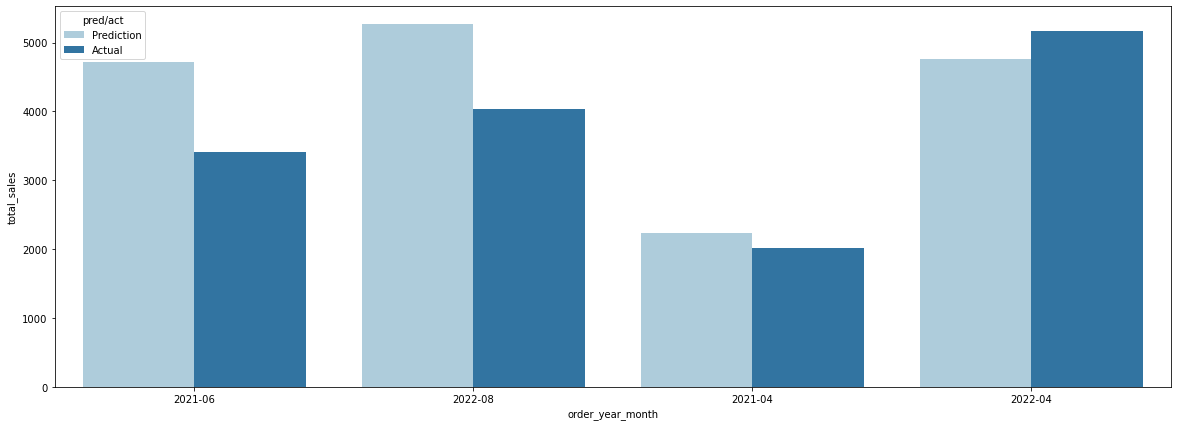

In [101]:
df1 = X_test[['merchant_abn', 'order_year_month']]
df1['total_sales'] = y_pred
df1['pred/act'] = 'Prediction'

df2 = X_test[['merchant_abn', 'order_year_month']]
df2['total_sales'] = y_test
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

df_vis = df_visualise[df_visualise['merchant_abn'] == 98957925622]
plt.figure(figsize=(20, 7))
sns.barplot(
    x="order_year_month", y="total_sales", hue="pred/act", data=df_vis, ci=95, 
    palette="Paired"
)
plt.show()

In [102]:
df_visualise[df_visualise['merchant_abn'] == 98957925622]

,merchant_abn,order_year_month,total_sales,pred/act
2210,98957925622,2021-06,4712.220811,Prediction
1583,98957925622,2022-08,5261.552934,Prediction
712,98957925622,2021-04,2230.342245,Prediction
3041,98957925622,2022-04,4765.708153,Prediction
2210,98957925622,2021-06,3411.520104,Actual
1583,98957925622,2022-08,4039.179538,Actual
712,98957925622,2021-04,2016.395358,Actual
3041,98957925622,2022-04,5168.070504,Actual


# To-do: Split Train Test by the merchant_abn instead of random

---
# Backlog

In [28]:
# conda install py-xgboost-gpu
# pip install xgboost

In [29]:
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=.33, n_splits=1, random_state = 7).split(df, groups=df['merchant_abn'])

X_train_inds, X_test_inds = next(gss)

train_data= df.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['merchant_abn','annual_trx_val'])]
y_train = train_data.loc[:, train_data.columns.isin(['annual_trx_val'])]

groups = train_data.groupby('merchant_abn').size().to_frame('size')['size'].to_numpy()

test_data = df.iloc[X_test_inds]

#We need to keep the id for later predictions
X_test = test_data.loc[:, ~test_data.columns.isin(['annual_trx_val'])]
y_test = test_data.loc[:, test_data.columns.isin(['annual_trx_val'])]

In [41]:
y_train

,annual_trx_val
0,-0.469737
1,-0.315885
2,-0.216104
3,-0.456162
4,-0.472509
...,...
173,-0.317912
174,-0.446038
175,-0.263348
176,0.242387


In [42]:
model = xgb.XGBRanker(
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )

model.fit(X_train, y_train, group=groups)


XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.9, early_stopping_rounds=None,
          enable_categorical=False, eta=0.05, eval_metric=None, gamma=0,
          gpu_id=-1, grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.1, max_bin=256,
          max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
          min_child_weight=1, missing=nan, monotone_constraints='()',
          n_estimators=110, n_jobs=0, num_parallel_tree=1, predictor='auto',
          random_state=42, reg_alpha=0, ...)

In [43]:
def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(['merchant_abn'])])
  
predictions = (X_test.groupby('merchant_abn').apply(lambda x: predict(model, x)))

In [44]:
predictions

merchant_abn
13297955415    [0.5]
15965199256    [0.5]
18126169589    [0.5]
20642885273    [0.5]
22474703869    [0.5]
22615718811    [0.5]
23692710924    [0.5]
23754348523    [0.5]
26063968667    [0.5]
27581734019    [0.5]
28049322288    [0.5]
32709729094    [0.5]
32842076466    [0.5]
33607911449    [0.5]
33885350311    [0.5]
36800720158    [0.5]
41108543298    [0.5]
41485392864    [0.5]
41528904756    [0.5]
44780100984    [0.5]
46630037650    [0.5]
49212265466    [0.5]
50859331573    [0.5]
50951615219    [0.5]
51659779274    [0.5]
55597122840    [0.5]
56014638362    [0.5]
56659127324    [0.5]
57508813253    [0.5]
59190126409    [0.5]
61562383191    [0.5]
62499158977    [0.5]
63358217962    [0.5]
63549963476    [0.5]
66650274915    [0.5]
68581310909    [0.5]
69381712591    [0.5]
70067721091    [0.5]
73416415122    [0.5]
73619221575    [0.5]
74024744735    [0.5]
74505118182    [0.5]
75726900852    [0.5]
75900778714    [0.5]
77149983383    [0.5]
78187460332    [0.5]
78213188724    [0.5]


In [32]:
df_merchant_sa2 = (df_cat['merchant_abn', 'sa2_maincode_2016', 'order_id']
                   .groupby(['merchant_abn', 'sa2_maincode_2016'])
                   .agg(count('order_id'))
                   .sort('merchant_abn'))

df_merchant_sa2 = df_merchant_sa2.withColumn('max_count', 
                                             F.max('count(order_id)').over(w))\
                    .where(F.col('count(order_id)') == F.col('max_count'))\
                    .drop('max_count')

In [35]:
df_merchant_sa2.filter(F.col('merchant_abn') == 10385163239).sort('count(order_id)', ascending=False)

merchant_abn,sa2_maincode_2016,count(order_id)
10385163239,117031334.0,2
10385163239,205031093.0,2
10385163239,101041022.0,1
10385163239,102011030.0,1
10385163239,105011096.0,1
10385163239,107021135.0,1
10385163239,105011094.0,1
10385163239,203011035.0,1
10385163239,106031123.0,1
10385163239,206041121.0,1
